In [2]:
import pandas as pd
import numpy as np

In [300]:
order = 40
states = 10
lookAhead = 10


transitionProbabilities = np.zeros((states, states))

transitionCounts = np.zeros((states, states))

transitionStateCounts = np.zeros(states)



In [301]:
def jsonToDataFrame(stockData):
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    dates = []

    for key in stockData:
        (open_, high, low, close, volume) = stockData[key]
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        closes.append(close)
        volumes.append(volume)
        dates.append(key)

    data = {'Date':dates, 'Open':opens, 'High':highs, 'Low':lows, 'Close':closes, 'Volume': volumes}

    return pd.DataFrame(data=data)

In [302]:



def convertArrayToTimeSeries(array, duration):
    length = len(array) - duration
    if(length <= 0):
        return np.ndarray((0,duration))

    subTimeSeries = np.ndarray((length, duration))
    for i in range(0, length):
        subTimeSeries[i] = array[i:i+duration]
    return subTimeSeries

def normalizeTimeSerie(timeSerie):
    avg = np.mean(timeSerie)
    var = np.var(timeSerie)
    if(var == 0):
        return np.zeros(timeSerie.shape)
    else:
        return (timeSerie - avg)/var

def normalizeTimeSeries(timeSeries):
    avg = np.mean(timeSeries, axis=1)
    var = np.var(timeSeries, axis=1)
    

    timeSeriesNorm = np.ndarray(timeSeries.shape)
    for i in range(len(timeSeries)):
        if(var[i] == 0):
            timeSeriesNorm[i] = np.zeros(timeSeries[i].shape)
        else:
            timeSeriesNorm[i] = (timeSeries[i] - avg[i])/var[i]
    return timeSeriesNorm




In [303]:
from convertStockToJson import getJsonDataFromFile

def loadTimeSeriesNormalized(name):
    stockData = getJsonDataFromFile(name)
    stockDatadf = jsonToDataFrame(stockData) 
    subTimeSeries = convertArrayToTimeSeries(stockDatadf['Close'], order)
    return normalizeTimeSeries(subTimeSeries)


In [304]:
stockNameTrainedOn = 'NAB'



subTimeSeriesNorm = loadTimeSeriesNormalized(stockNameTrainedOn)[:-365]
print(len(subTimeSeriesNorm))

1362


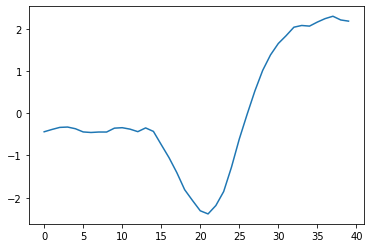

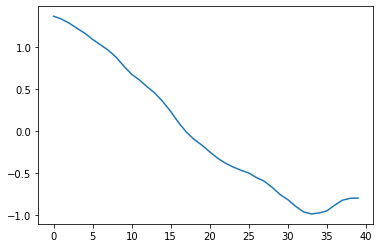

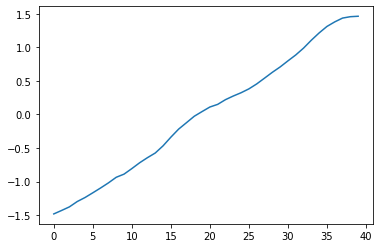

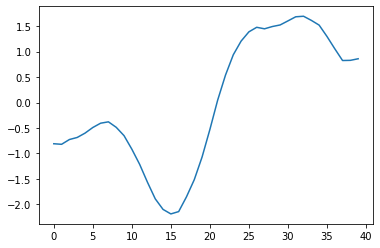

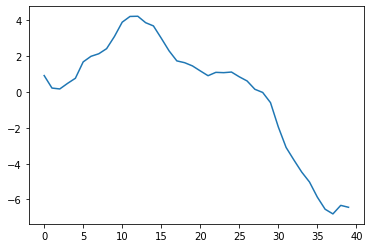

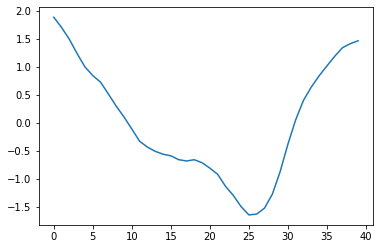

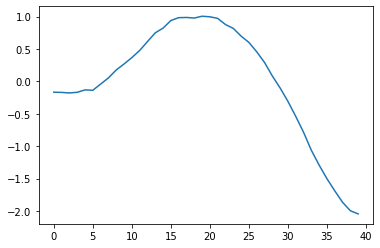

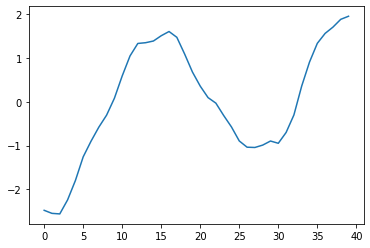

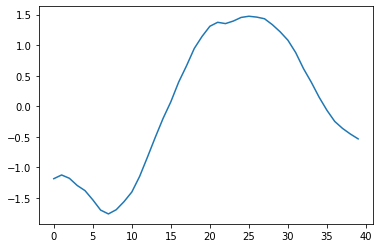

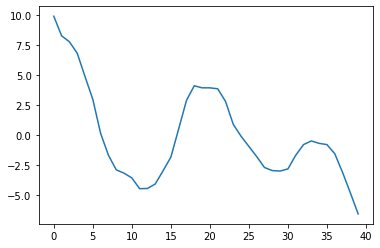

In [350]:
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import matplotlib.pyplot as plt




kmeans = KMeans(n_clusters=states, random_state=0).fit(subTimeSeriesNorm)
cluserCenters = kmeans.cluster_centers_


for cluster in cluserCenters:
   
    plt.plot(cluster)
    plt.show()






fig, axs = plt.subplots(states, states)
fig.set_size_inches(18.5, 10.5)
for currentState in range(states):
    for nextState in range(states):
        last = cluserCenters[currentState][-1]
        dif = last - cluserCenters[nextState][0]

        clusterNextStateCopy = cluserCenters[nextState].copy()
        clusterNextStateCopy += dif

        pltData = np.concatenate((cluserCenters[currentState], clusterNextStateCopy[1:]))

        axs[currentState, nextState].axvline(x=order)
        
     

        axs[currentState, nextState].plot(pltData)

        axs[currentState, nextState].set_title('Axis ' + str(currentState) + ", " + str(nextState))

plt.plot(cluster)



In [306]:

buysOrSells = np.zeros(states) #VAS

#buysOrSells = np.array([0.0,1,-1,-1,0,1,-0.7,0.5]) #ANZ

for i in range(states):
    buysOrSells[i] = cluserCenters[i][-1] - cluserCenters[i][0]


buysOrSells = (buysOrSells - np.mean(buysOrSells))/np.var(buysOrSells)

print(buysOrSells)


[ 0.12200553 -0.01644241  0.13142518  0.09440428 -0.16700133  0.0339112
 -0.00835822  0.17474825  0.06495863 -0.42965111]


In [307]:
def predictStateVector(timeSerieNorm):
    distances = kmeans.transform([timeSerieNorm])[0]
    minDis = np.min(distances)
    maxDis = np.max(distances)
    distances -= minDis
    distances /= maxDis
    distances = 1 - distances
    distances = distances * distances * distances
    return distances


def predictStatesVector(timeSerieNorms):
    result = np.zeros((timeSerieNorms.shape[0], states))
    for i in range(len(timeSerieNorms)):
        result[i] = predictStateVector(timeSerieNorms[i])
    return result

    distances = kmeans.transform(timeSerieNorms)
    minDis = np.min(distances, axis=1)
    maxDis = np.max(distances, axis=1)
    for i in range(len(distances)):
        distances[i] -= minDis[i]
        distances[i] /= maxDis[i]
        distances[i] = 1 - distances[i]
        distances[i] = distances[i] * distances[i] * distances[i]
    return distances
    

In [308]:

def trainMarkokChain(timeSeriesNormalized):
    subSeriesClassifified = kmeans.predict(subTimeSeriesNorm)
    for i in range(len(subSeriesClassifified)-lookAhead):
        currentState = subSeriesClassifified[i]
        nextState = subSeriesClassifified[i+lookAhead]
        
        transitionCounts[currentState, nextState] += 1
        transitionStateCounts[currentState] += 1

def trainMarkokChainContinous(timeSeriesNormalized):
    global transitionCounts, transitionStateCounts
    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized)

    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        
        currentState = timeSeriesKMeanDistances[i]
        nextState = timeSeriesKMeanDistances[i+lookAhead]
        nextStateMat = np.tile(nextState, (len(nextState), 1))
        adjust = (nextStateMat.transpose() * currentState).transpose()
        transitionCounts += adjust
        transitionStateCounts += np.sum(adjust, axis=1)



#trainMarkokChain(subTimeSeriesNorm)
trainMarkokChainContinous(subTimeSeriesNorm)


print(transitionCounts)
print(transitionStateCounts)

[[340.18454812 362.52397828 488.12196987 410.00834915  44.60345548
  335.66742686 384.92306553 327.75674579 434.78674383  16.90753298]
 [419.74409179 616.60254869 524.57748137 443.24845373  68.95196132
  529.899366   516.36884244 388.25025905 446.44882343  31.95030351]
 [452.70867221 512.23235928 650.71184651 526.37984199  64.48592083
  456.62359392 534.27894584 463.32627033 569.29913398  18.76681005]
 [362.34600127 414.55858801 532.95129888 425.49582729  56.61531276
  366.1811234  449.87959942 384.61866408 478.2661312   16.80799435]
 [ 48.64378511  86.5090493   54.01568968  45.33099865  20.73277871
   69.25840578  70.53809141  47.3442054   46.41197451   6.62677273]
 [395.1270452  466.02617721 515.93111241 447.1371155   55.68796374
  426.94232609 434.63896991 354.12720857 443.64149594  25.4393765 ]
 [367.3858702  579.90111042 479.85655943 390.00679096  69.67283063
  466.0016811  505.86354493 376.55193693 414.58850415  21.94646993]
 [343.74215512 398.10229274 453.05124194 385.08322002  

In [337]:
def updateProbabilities():
    for i in range(transitionProbabilities.shape[0]):
        if(transitionStateCounts[i] != 0):
            for j in range(transitionProbabilities.shape[1]):
                transitionProbabilities[i, j] = transitionCounts[i, j]/transitionStateCounts[i]

updateProbabilities()
print(transitionProbabilities)
transitionProbabilities = np.linalg.matrix_power(transitionProbabilities, 10)
print(transitionProbabilities)

[[0.10815015 0.11525222 0.15518184 0.13034826 0.01418016 0.10671408
  0.12237325 0.10419915 0.13822571 0.00537518]
 [0.10530348 0.15469042 0.1316036  0.11120014 0.01729835 0.13293873
  0.12954425 0.09740245 0.11200304 0.00801555]
 [0.10654944 0.12055892 0.15315143 0.12388867 0.0151774  0.10747085
  0.1257478  0.10904839 0.13399015 0.00441695]
 [0.10389193 0.11886233 0.15280791 0.12199826 0.01623275 0.10499153
  0.12898958 0.11027795 0.13712857 0.00481919]
 [0.0981886  0.1746205  0.10903191 0.09150166 0.04184959 0.13979968
  0.14238276 0.09556537 0.09368364 0.01337629]
 [0.11084444 0.13073368 0.14473344 0.12543475 0.01562207 0.11976954
  0.12192867 0.09934281 0.12445413 0.00713647]
 [0.10005674 0.1579348  0.13068789 0.1062175  0.01897524 0.12691454
  0.13777083 0.1025531  0.11291228 0.00597707]
 [0.11114976 0.12872723 0.14649509 0.12451749 0.01559352 0.11538063
  0.1237076  0.10399681 0.12558713 0.00484475]
 [0.10235091 0.13119873 0.14481661 0.11473679 0.01840416 0.11027082
  0.13411228

In [338]:
def loadTimeSeriesClassified(name):
    normalized = loadTimeSeriesNormalized(name)
    if(normalized.shape[0] > 0):
        return (kmeans.predict(normalized), True)
    else:
        return (None, False)

In [339]:
def testMarkovChain(subSeriesClassifified):
    numCorrect = 0
    length = len(subSeriesClassifified)-lookAhead
    for i in range(length):
        currentState = subSeriesClassifified[i]
        nextStateCorrect = subSeriesClassifified[i+lookAhead]
        nextStatePredict = np.argmax(transitionStateCounts[currentState])
        if(nextStatePredict == nextStateCorrect):
            numCorrect += 1
    if(length > 0):
        return numCorrect/length
    else:
        return None

In [340]:
from filesInPath import filesInPath

filenames = filesInPath('data')
import random

# random.shuffle(filenames)
# filenames = filenames[:40]
filenames = ['VAS', 'IOO', 'XRO', 'ANZ']

for (fileName,i) in zip(filenames, range(len(filenames))):
    #fileName = fileName[:-5]
 
    (timeSeriesClassified, success) = loadTimeSeriesClassified(fileName)  
    if(success):  
        percetage = testMarkovChain(timeSeriesClassified)  
        if(percetage != None):
            print(fileName + ",  " + str(percetage * 100 ) + "%")


VAS,  2.9052876234747242%
IOO,  2.0408163265306123%
XRO,  2.9651162790697674%
ANZ,  5.523255813953488%


In [341]:

def shouldBuyorSells(timeSeries):
    timeSerieNorms = normalizeTimeSeries(timeSeries)
    rankings = predictStatesVector(timeSerieNorms)
    return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells))



def shoudlBuyorSell(timeSerie):
    #currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
    timeSerieNorm = normalizeTimeSeries(np.array([timeSerie]))[0]
    rankings = predictStateVector(timeSerieNorm)
    return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells) )


In [342]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False
        
        if(daysShouldWaitToSell == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    daysShouldWaitToSell = lookAhead
                    didBuy = True


        elif(daysShouldWaitToSell == 0):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                daysShouldWaitToSell = None
                didSell = True
        else:
            daysShouldWaitToSell -= 1
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 1
    stopLoss = -0.03

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor)-1 if boughtFor!=None else None
        print(profitLoss )
        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss):
            #should sell
            print('Should sell' + str(profitLoss) + " " + str(boughtFor) + " " + str(stockPosition))
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.03
    stopLoss = -0.03
    sellThreshold = -0.35

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor) - 1 if boughtFor!=None else None
        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss or sellThreshold > signal):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower

In [343]:
def thresholdRange(subTimeSeries, steps = 20):
    signals = np.ndarray((len(subTimeSeries)))
   
    for i in range(len(subTimeSeries)):
        signals[i] = shoudlBuyorSell(subTimeSeries[i])
   
    minSig = np.min(signals)
    maxSig = np.max(signals)
    return np.arange(minSig, maxSig, (maxSig-minSig)/steps)



In [344]:
print(len(subTimeSeriesNorm))

1362


In [345]:

stockPriceHistory = jsonToDataFrame(getJsonDataFromFile(stockNameTrainedOn))['Close']

subTimeSeries = convertArrayToTimeSeries(stockPriceHistory, order)[len(subTimeSeriesNorm):]


In [351]:


bestthreshold = -np.inf
bestPrice = -np.inf
for threshold in thresholdRange(subTimeSeries):
    price = runModelAgainst(subTimeSeries, threshold)
    if(bestPrice < price):
        bestPrice = price
        bestthreshold = threshold
    print((price, threshold))

(917.2300000000002, 0.1876561237817878)
(825.3799999999998, 0.20336131694900295)
(977.75, 0.21906651011621808)
(867.6899999999997, 0.23477170328343322)
(884.3700000000003, 0.25047689645064836)
(911.5500000000003, 0.2661820896178635)
(964.77, 0.28188728278507863)
(1059.1700000000005, 0.29759247595229377)
(973.1300000000003, 0.3132976691195089)
(1054.4300000000007, 0.32900286228672404)
(985.0199999999999, 0.3447080554539392)
(1170.3199999999997, 0.3604132486211543)
(1067.6799999999998, 0.37611844178836945)
(1028.0900000000001, 0.3918236349555846)
(1059.4, 0.4075288281227997)
(1014.3999999999997, 0.42323402129001486)
(1050.24, 0.43893921445723)
(1057.4, 0.45464440762444513)
(1023.9100000000001, 0.47034960079166027)
(1007.37, 0.4860547939588754)


In [346]:

def trackModel(threshold):
    equity = np.zeros(len(subTimeSeries))
    monies = np.zeros(len( ))
    stockOverTime = np.zeros(len(subTimeSeries))
    buys = []
    hasBuys = [False]
    sells = []
    hasSells = [False]
    stockPrices = []
    signals = []
    def record(state):
        (i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal) = state
        buys.append(stockPrice if didBuy else None)
        sells.append(stockPrice if didSell else None)
        if(didBuy):
            hasBuys[0] = True
        if(didSell):
            hasSells[0] = True
        stockPrices.append(stockPrice)
        signals.append(signal)
        equity[i] = buyingPower + stocks*stockPrice
        monies[i] = buyingPower
        stockOverTime[i] = stocks*stockPrice

    runModelAgainst(subTimeSeries, threshold, record)

    plt.plot(equity)
    plt.xlabel('Time (days)')
    plt.ylabel('Equity ($)')
    plt.show()

    plt.plot(monies, c='blue')
    plt.plot(stockOverTime, c='red')
    plt.show()

    fig,ax = plt.subplots()
    ax.plot(stockPrices)
    ax.set_ylabel("Stock Price ($)")
    ax.set_xlabel("Time (days)")
    if(hasBuys[0]):
        ax.scatter(np.arange(len(buys)), buys, c='green')
    if(hasSells[0]):
        ax.scatter(np.arange(len(sells)), sells, c='red')
    ax2=ax.twinx()
    ax2.plot(signals,c='black', alpha=0.2)
    ax2.plot([0, len(signals)-1], [threshold, threshold], c='red', alpha=0.2)
    ax2.set_ylabel('Signal, Future Prediction')
    fig.show()
    plt.show()

    plt.plot(signals)
    plt.show()

0.44940934323537307


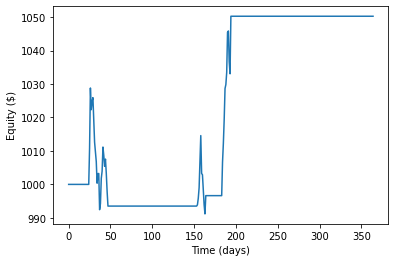

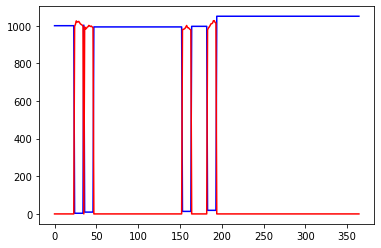

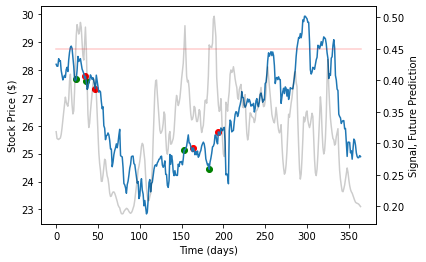

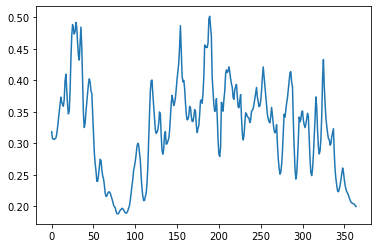

0.397058699344656


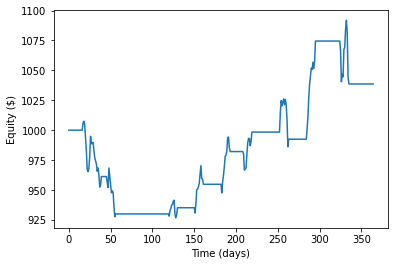

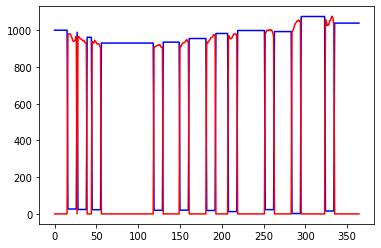

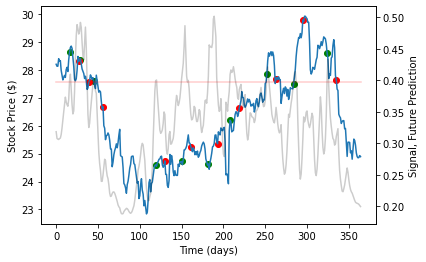

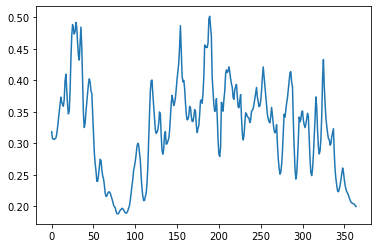

0.3447080554539389


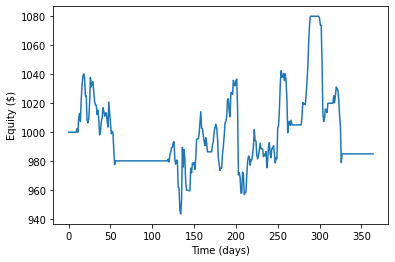

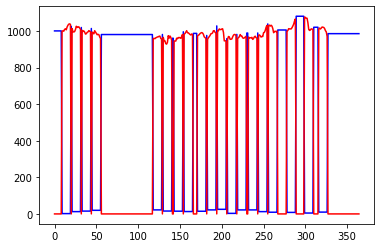

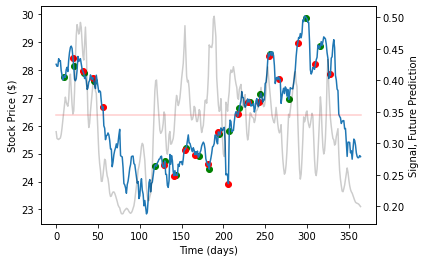

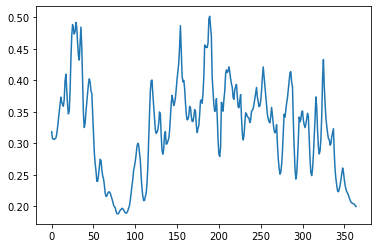

0.29235741156322187


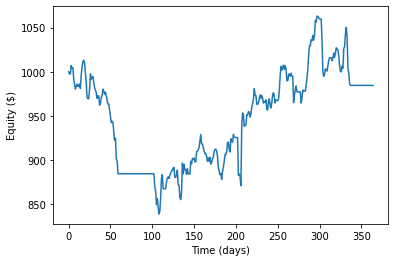

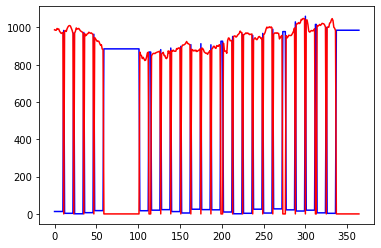

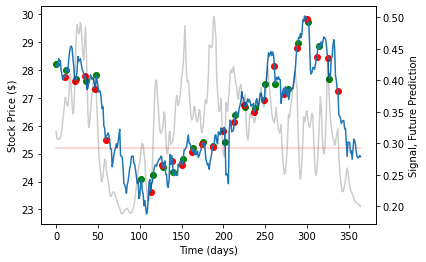

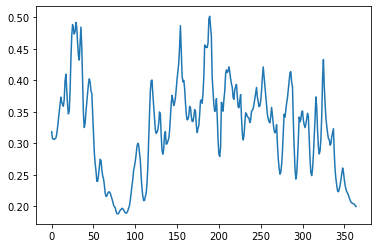

0.2400067676725048


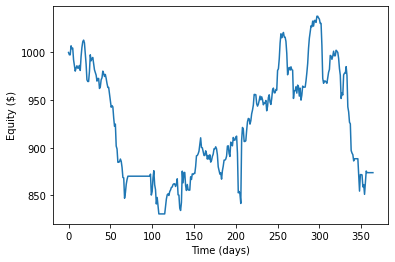

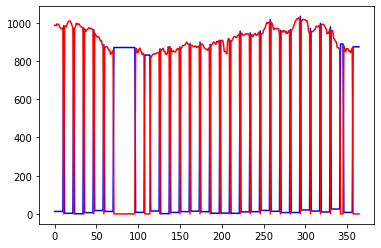

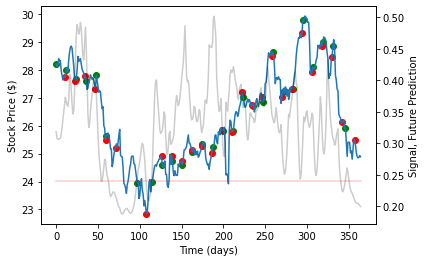

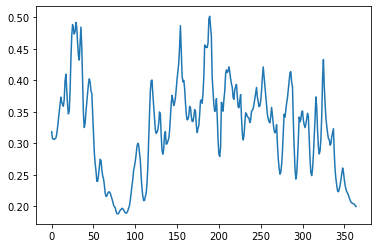

0.18765612378178775


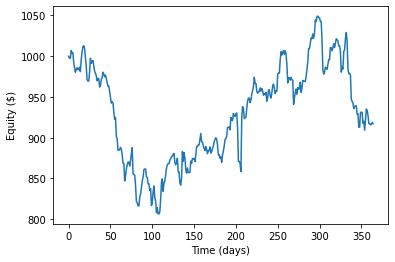

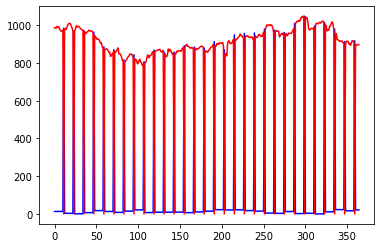

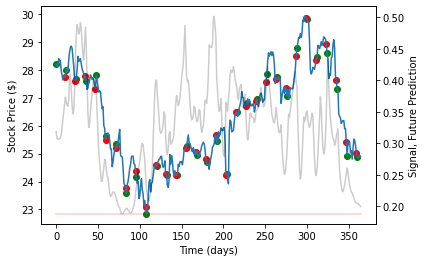

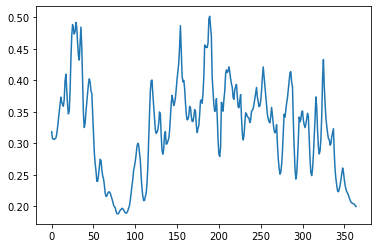

In [347]:
for threshold in thresholdRange(subTimeSeries, 6)[::-1]:
    print(threshold)
    trackModel(threshold)

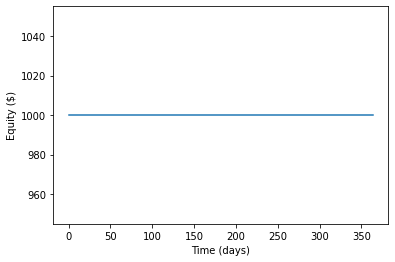

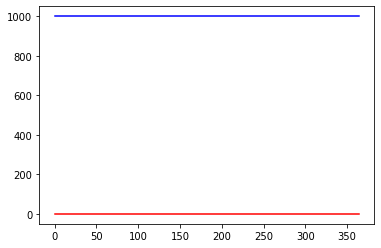

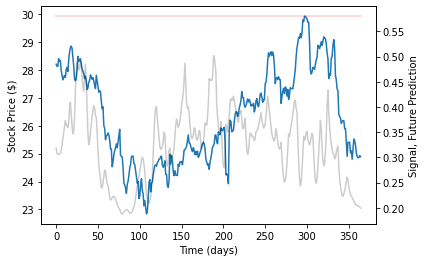

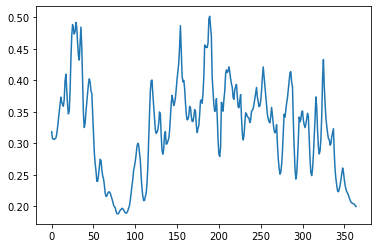

In [348]:
trackModel(0.58)

0


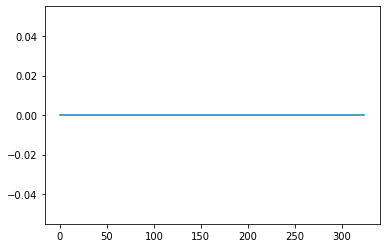

In [349]:
buys = []
sells = []
stockPrices = []
signals = []
profits = []

daysShouldWaitToSell = None


for i in range(len(subTimeSeries) - order):
    stockPrice = subTimeSeries[i][-1]
    stockPriceFuture = subTimeSeries[i+order][-1]
    signal = shoudlBuyorSell(subTimeSeries[i])

    buys.append(None)
    sells.append(None)
    stockPrices.append(stockPrice)
    signals.append(signal)
    profits.append(0)
    if(signal > 1.8):
        #buy
        buys[i] = stockPrice  
        profit = stockPriceFuture - stockPrice
        profits[i] = profit


print(np.sum(profits))
plt.plot(profits)
plt.show()